In [215]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.sparse import csc_matrix, linalg as sla
from scipy.optimize import root, curve_fit
from scipy.special import iv, kv

In [216]:
R1 = 0.1
R2 = 8
r = np.linspace(R1, R2, 1000)
dr = (np.max(r)-np.min(r))/(len(r)-1)
n0 = (8/r**2)*(np.tanh(25*(r-3))-np.tanh(25*(r-5)))
a = 2*(2-1)/(2+1)
r1 = 3
r2 = r1*(2+a)/(2-a)
print(r2, 2*(r2-r1)/(r2+r1))
n0 = (8/r**2)*(np.tanh(25*(r-r1))-np.tanh(25*(r-r2)))
#n0 = (r**-1.5 - R2**-1.5)/R1**-1.5
#n0[:50] = 0
#n0[200:] = 0
#n0 = np.exp(-(r-R1)*5)
#n0 = np.exp(-((r-4.5)/1)**2)
#n0 = np.zeros(len(r))
#n0[:50] = 1
#phi_wire = -10
n0[0] = 0
phi_wire = 0
h_T = -phi_wire/np.log(R1/R2)

5.999999999999999 0.6666666666666665


In [217]:
#Poisson Solver
@njit(parallel=True)
def M(r, dr):
    col = np.zeros(3*len(r)-4)
    row = np.zeros(3*len(r)-4)
    data = np.zeros(3*len(r)-4)
    data[0] = 1
    for i in prange(1, len(r)-1):
        row[3*i-1:3*i+2] = i
        col[3*i-1] = i-1
        col[3*i] = i
        col[3*i+1] = i+1
        data[3*i-1] = (r[i]-dr/2)/(dr**2*r[i])
        data[3*i] = -2/dr**2
        data[3*i+1] = (r[i]+dr/2)/(dr**2*r[i])
    row[-1] = len(r)-1
    col[-1] = len(r)-1
    data[-1] = len(r)-1
    return data, col, row

In [218]:
I0 = iv(0, r)
I1 = iv(1, r)
dI0 = np.zeros(len(r))
for i in range(len(r)-1):
    dI0[i] = (I0[i+1]-I0[i])/dr
dI0[-1] = 2*dI0[-2] - dI0[-3]

K0 = kv(0, r)
K1 = kv(1, r)
dK0 = np.zeros(len(r))
for i in range(len(r)-1):
    dK0[i] = (K0[i+1]-K0[i])/dr
dK0[-1] = 2*dK0[-2] - dK0[-3]

#plt.plot(r, I0, label='I0')
#plt.plot(r, I1, label='I1')
#plt.plot(r, dI0, label='dI0', linestyle='dashed')
#plt.legend()
#plt.show()

#plt.plot(r, K0, label='K0')
#plt.plot(r, K1, label='K1')
#plt.plot(r, -dK0, label='dK0', linestyle='dashed')
#plt.legend()
#plt.show()

In [219]:
def alpha(r, r_j):
    return(iv(0, r)*kv(0, r_j)-iv(0, r_j)*kv(0, r))
def dalpha(r, r_j):
    return(iv(1, r)*kv(0, r_j)+iv(0, r_j)*kv(1, r))

In [220]:
@njit(parallel=True)
def Green(r, r_prime, r_i, r_o, alpha_inv, alpha1, alpha2):
    green = np.empty((len(r_prime), len(r)))
    for i in prange(len(r)):
        for j in range(len(r_prime)):
            if r[i] <= r_prime[j]:
                green[i, j] = alpha1[i]*alpha2[j]/alpha_inv[j]
            elif r[i]>r_prime[j]:
                green[i, j] = alpha2[i]*alpha1[j]/alpha_inv[j]
    return green

In [221]:
alpha_inv = r*(alpha(r, R1)*dalpha(r, R2)-alpha(r, R2)*dalpha(r, R1))
alpha1 = alpha(r, R1)
alpha2 = alpha(r, R2)
#plt.plot(r, alpha1, label='1')
#plt.plot(r, alpha2, label='2')
#plt.plot(r, 1/alpha_inv, label='3')
#plt.legend()
#plt.show()
green = Green(r, r, R1, R2, alpha_inv, alpha1, alpha2)
#plt.imshow(green)
#plt.show()

phi_green = np.zeros(len(r))
for i in range(len(r)):
    phi_green[i] = np.sum(r*green[i]*n0*dr)

#plt.plot(r, phi_green, color='g', linestyle='dashed')
#plt.show()

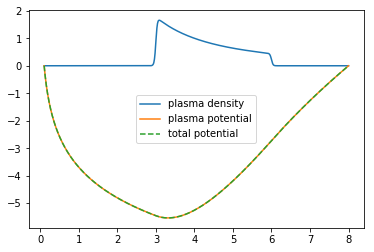

In [222]:
data, col, row = M(r, dr)
A = csc_matrix((data, (row, col)), shape=(len(r), len(r)))
lu = sla.splu(A)

phi = lu.solve(n0)
phi_T = (phi_wire/np.log(R1/R2))*np.log(r/R2)

plt.plot(r, n0, label='plasma density')
plt.plot(r, phi, label='plasma potential')
plt.plot(r, phi+phi_T, label='total potential', linestyle="dashed")
plt.legend()
plt.show()

dn0 = np.zeros(len(r))
in0 = np.zeros(len(r))
dphi = np.zeros(len(r))

dn0[0] = (r[1]**2*n0[1] - r[0]**2*n0[0])/dr
in0[0] = dr*(r[1]*n0[1] + r[0]*n0[0])/2
dphi[0] = (r[0]+dr/2)*(phi[1]-phi[0])/dr
for i in range(len(r)-1):
    dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
    in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dphi[i] = (r[i]+dr/2)*(phi[i+1]-phi[i])/dr
dn0[-1] = 2*dn0[-2] - dn0[-3]
in0[-1] = 2*in0[-2] - in0[-3]
dphi[-1] = 2*dphi[-2] - dphi[-3]
dphi = dphi - dphi[0]

#plt.plot(r, dn0, label='d/dr (r^2*n0)')
#plt.legend()
#plt.show()

#plt.plot(r, in0, label='int(r*n0)')
#plt.plot(r, dphi, label='d/dr (r*phi0)', linestyle='dashed')
#plt.legend()
#plt.show()

in0 += h_T

In [223]:
N = np.empty((len(r), len(r)))
for i in range(len(r)):
    N[i] = -(dn0[i]/r[i])*r*green[i]*dr
    N[i, i] += in0[i]
#w, v = sp.linalg.eig(N)
w, v = np.linalg.eig(N)
v = np.transpose(v)

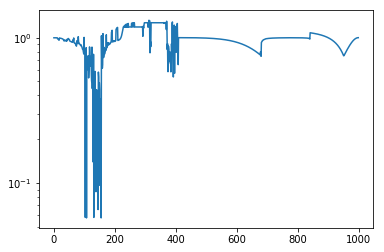

0.05744889407457318 0.18128770033802227 155
accepted 103
accepted 107
rejectred 131
rejectred 145
rejectred 155
[103, 107]


In [224]:
v_real = np.real(v)
sum_der = np.zeros(len(v_real))
max_v  = np.max(abs(v_real))

for i in range(len(v_real)):
    sum_der[i] = np.max(abs(v_real[i, 1:]-v_real[i, :-1])/np.max(abs(v_real)))
plt.plot(sum_der)
plt.yscale("log")
plt.show()
print(np.min(sum_der), np.std(sum_der), np.argmin(sum_der))

target = np.min(sum_der)+0.1*np.std(sum_der)
i_target = []
for i in range(len(v_real)-1):
    if sum_der[i] <= target:
        n = 0
        for j in range(len(v_real[0])-1):
            if abs(v_real[i][j+1]/max_v)<=1e-6 and abs(v_real[i][j-1]/max_v)<=1e-6 and abs(v_real[i][j]/max_v)>=0.005:
                n += 1
        if n == 0:
            print("accepted", i)
            i_target.append(i)
            #plt.plot(r, v_real[i], label=str(np.real(w[i])/2))
            #plt.legend()
            #plt.show()
        else:
            print("rejectred", i)
            #plt.plot(r, v_real[i], label=str(np.real(w[i])/2))
            #plt.legend()
            #plt.show()
print(i_target)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


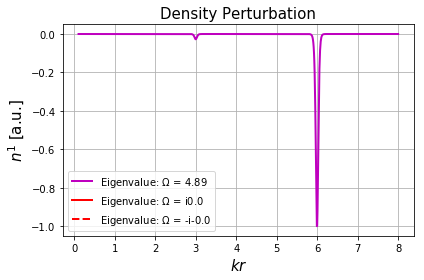

In [225]:
plt.plot(r, np.real(v[int(i_target[0])])/np.max(abs(np.real(v[int(i_target[0])]))), 'm', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[0])])/2, 2)), linewidth=2)
plt.plot(r, np.imag(v[int(i_target[0])])/np.max(abs(np.imag(v[int(i_target[0])]))), 'r', label='Eigenvalue: $\Omega$ = i'+str(round(np.imag(w[i_target[0]])/2, 2)), linewidth=2)
plt.plot(r, np.imag(v[int(i_target[1])])/np.max(abs(np.imag(v[int(i_target[1])]))), 'r', linestyle='dashed', label='Eigenvalue: $\Omega$ = -i'+str(round(np.imag(-w[i_target[1]])/2, 2)), linewidth=2)
#plt.plot(r, -v_real[int(i_target[1])]/np.max(abs(v_real[int(i_target[1])])), 'g', linestyle='dashed', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[1])])/2, 2))+' - i'+str(round(abs(np.imag(w[int(i_target[1])])/2), 2)), linewidth=2)

#plt.plot(r, n0/np.max(n0), 'r', linestyle='dotted', label='Initial Density', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
#plt.savefig('equi_vs_pert35.png', dpi=400)
plt.savefig('eigen_imag.png', dpi=400)
plt.show()

In [226]:
stop

NameError: name 'stop' is not defined

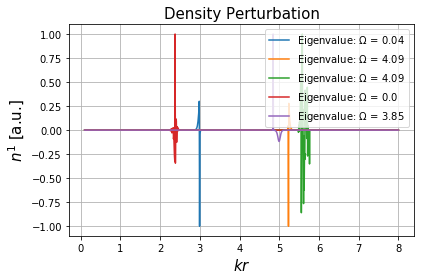

In [ ]:
plt.plot(r, np.real(v[int(200)])/np.max(abs(np.real(v[int(200)]))), label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(200)])/2, 2)))
plt.plot(r, np.real(v[int(250)])/np.max(abs(np.real(v[int(250)]))), label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(250)])/2, 2)))
plt.plot(r, np.real(v[int(300)])/np.max(abs(np.real(v[int(300)]))), label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(300)])/2, 2)))
plt.plot(r, np.real(v[int(350)])/np.max(abs(np.real(v[int(350)]))), label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(350)])/2, 2)))
plt.plot(r, np.real(v[int(86)])/np.max(abs(np.real(v[int(86)]))), label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(86)])/2, 2)))
plt.legend(loc=1)
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
#plt.savefig('eigenmodes.png', dpi=400)
plt.show()

In [ ]:
@njit(parallel=True)
def mode_finder(v_real):

    sum_der = np.zeros(len(v_real))
    v_abs = np.sqrt(v_real**2)
    max_v  = np.max(v_abs)

    for i in prange(len(v_real)):
        sum_der[i] = np.max(np.sqrt((v_real[i, 1:]-v_real[i, :-1])**2)/max_v)

    target = np.min(sum_der)+0.1*np.std(sum_der)
    i_target = np.zeros(len(v_real))
    for i in prange(len(v_real)-1):
        if sum_der[i] <= target:
            n = 0
            for j in range(len(v_real[0])-1):
                if v_abs[i][j+1]/max_v<=1e-6 and v_abs[i][j-1]/max_v<=1e-6 and v_abs[i][j]/max_v>=0.01:
                    n += 1
            if n == 0:
                i_target[i] = int(i)

    return i_target[i_target!=0]

In [ ]:
v_real = np.real(v)
i_target = mode_finder(v_real)
i_target = np.array([int(i) for i in i_target])
print(i_target)

[ 69 144]


In [ ]:
def shooting(r, dr, dn0, in0, omega):
    @njit(parallel = True)
    def fun(omega):

        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = ((r[i]-dr/2)/(dr**2*r[i]))
            drm = -2/dr**2
            drr = -((dr**2*r[i])/(r[i]+dr/2))
            diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
            diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

    fjac: array([[ 0.78879058,  0.61466203],
       [-0.61466203,  0.78879058]])
     fun: array([-1.04687235e-10,  2.66653469e-09])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([5.07383229e-06, 9.72448194e-06])
       r: array([4825.43202842, -409.15942723, 5602.06276704])
  status: 1
 success: True
       x: array([2.74750151e+00, 4.74001329e-13])
[1.37375076e+00 2.37000664e-13]


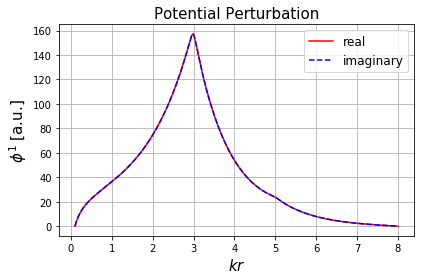

In [ ]:
bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend(fontsize=12)
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$\phi^1$ [a.u.]', fontsize=15)
plt.title('Potential Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
#plt.savefig('shooting_potential.png', dpi=400)
plt.show()

[437, 558]


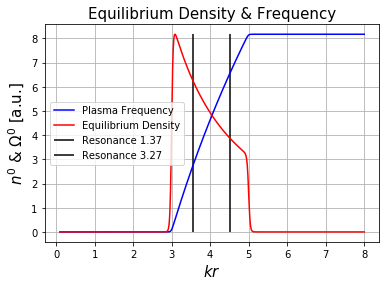

In [ ]:
n1 = A.dot(-phi_r)
v_real = np.real(v)

i_res = []
for i in range(len(i_target)):
    i_res.append(np.argmin(abs(in0-np.real(w[i_target[i]]))))
print(i_res)
plt.plot(r, in0, "b", label='Plasma Frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='Equilibrium Density')
for i in range(len(i_res)):
    plt.vlines(r[i_res[i]], 0, np.max(in0), "k", label='Resonance '+str(round(np.real(w[i_target[i]])/2, 2)))
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^0$ & $\Omega^0$ [a.u.]', fontsize=15)
plt.legend()
plt.title('Equilibrium Density & Frequency', fontsize=15)
plt.grid()
#plt.savefig('resonance.png', dpi=400)
plt.show()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


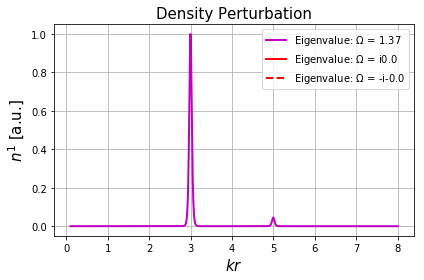

In [ ]:
#real
#plt.plot(r, n1/np.max(n1), label='Shooting: $\Omega$ = '+str(round(omega[0]/2, 2)), color="k", linewidth=2)
#plt.plot(r, np.real(v[int(i_target[1])])/np.max(abs(np.real(v[int(i_target[1])]))), 'b', linestyle='dashed', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[1])])/2, 2)), linewidth=2)
#plt.plot(r, -np.real(v[int(i_target[0])])/np.max(abs(np.real(v[int(i_target[0])]))), 'g', linestyle='dashed', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[0])])/2, 2)), linewidth=2)
#imaginary
plt.plot(r, np.real(v[int(i_target[0])])/np.max(abs(np.real(v[int(i_target[0])]))), 'm', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[0])])/2, 2)), linewidth=2)
plt.plot(r, np.imag(v[int(i_target[0])])/np.max(abs(np.imag(v[int(i_target[0])]))), 'r', label='Eigenvalue: $\Omega$ = i'+str(round(np.imag(w[i_target[0]])/2, 2)), linewidth=2)
plt.plot(r, np.imag(v[int(i_target[1])])/np.max(abs(np.imag(v[int(i_target[1])]))), 'r', linestyle='dashed', label='Eigenvalue: $\Omega$ = -i'+str(round(np.imag(-w[i_target[1]])/2, 2)), linewidth=2)
#plt.plot(r, -v_real[int(i_target[1])]/np.max(abs(v_real[int(i_target[1])])), 'g', linestyle='dashed', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[1])])/2, 2))+' - i'+str(round(abs(np.imag(w[int(i_target[1])])/2), 2)), linewidth=2)

#plt.plot(r, n0/np.max(n0), 'r', linestyle='dotted', label='Initial Density', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
#plt.savefig('equi_vs_pert35.png', dpi=400)
plt.savefig('eigen_imag.png', dpi=400)
plt.show()

In [ ]:
def phase_finder(n1_real, v_real, n1_imag, v_imag, para):
    def fun(para):
        real = np.sum((n1_real-para[0]*(v_real*np.cos(para[1])-v_imag*np.sin(para[1])))**2)
        imag = np.sum((n1_imag-para[0]*(v_real*np.sin(para[1])+v_imag*np.cos(para[1])))**2)
        return real, imag    
    Root = root(fun, para)
    return(Root)

    fjac: array([[-0.98963179, -0.14362772],
       [ 0.14362772, -0.98963179]])
     fun: array([6245907.81083897, 6241431.4529194 ])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 52
     qtf: array([-7079942.69126886, -5278893.99125123])
       r: array([ 1.23930912e+02,  1.58731687e+06, -4.74496488e+05])
  status: 5
 success: False
       x: array([-1.34643948e+04,  3.92450202e+00])
omega = 1.92pi


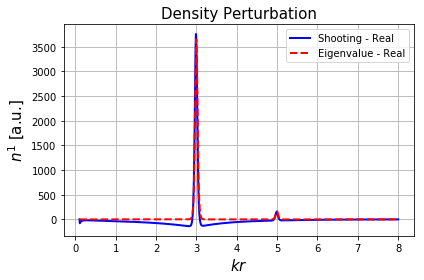

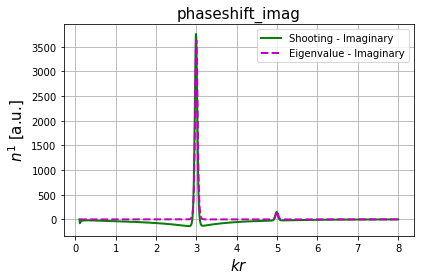

In [ ]:
n1_imag = A.dot(-phi_i)
n1_real = A.dot(-phi_r)
v_real = np.real(v[i_target[0]])
v_imag = np.imag(v[i_target[0]])
Root = phase_finder(n1_real, v_real, n1_imag, v_imag, [1e4, np.pi])
print(Root)
para = Root.x
print('omega = '+str(round((para[1]%2*np.pi)/np.pi, 2))+'pi')

plt.plot(r, n1_real, 'b', label='Shooting - Real', linewidth=2)
plt.plot(r, para[0]*(v_real*np.cos(para[1])-v_imag*np.sin(para[1])), 'r', linestyle='dashed', label='Eigenvalue - Real', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('phaseshift_real.png', dpi=400)
plt.show()

plt.plot(r, n1_imag, 'g', label='Shooting - Imaginary', linewidth=2)
plt.plot(r, para[0]*(v_real*np.sin(para[1])+v_imag*np.cos(para[1])), 'm', linestyle='dashed', label='Eigenvalue - Imaginary', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('phaseshift_imag', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('phaseshift_imag.png', dpi=400)
plt.show()

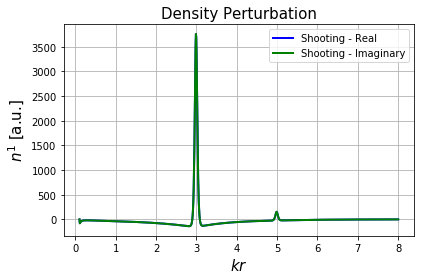

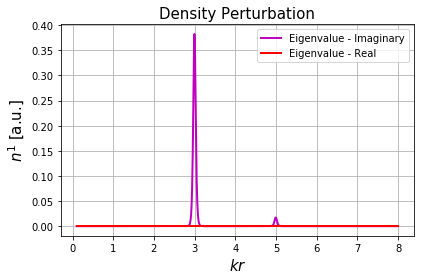

In [ ]:
plt.plot(r, n1_real, 'b', label='Shooting - Real', linewidth=2)
plt.plot(r, n1_imag, 'g', label='Shooting - Imaginary', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('shooting_imag.png', dpi=400)
plt.show()

plt.plot(r, v_real, 'm', label='Eigenvalue - Imaginary', linewidth=2)
plt.plot(r, v_imag, 'r', label='Eigenvalue - Real', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('eigen_imag.png', dpi=400)
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

    fjac: array([[-0.09285242, -0.99567988],
       [ 0.99567988, -0.09285242]])
     fun: array([0.03703687, 0.0238581 ])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 28
     qtf: array([-0.02719621,  0.03466506])
       r: array([-2.87250259e+02,  2.15998662e-03, -3.72081098e-03])
  status: 5
 success: False
       x: array([-2.41624671e-05,  2.68295935e+00])


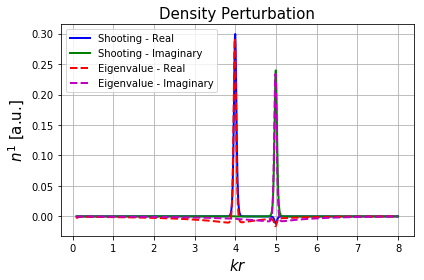

In [ ]:
n1_imag = A.dot(-phi_i)
n1_real = A.dot(-phi_r)
v_real = np.real(v[i_target[0]])
v_imag = np.imag(v[i_target[0]])
Root = phase_finder(v_real, n1_real, v_imag, n1_imag, [1e-4, np.pi])
print(Root)
para = Root.x

plt.plot(r, v_real, 'b', label='Shooting - Real', linewidth=2)
plt.plot(r, v_imag, 'g', label='Shooting - Imaginary', linewidth=2)
plt.plot(r, para[0]*n1_real*np.cos(para[1])-para[0]*n1_imag*np.sin(para[1]), 'r', linestyle='dashed', label='Eigenvalue - Real', linewidth=2)
plt.plot(r, para[0]*n1_real*np.sin(para[1])+para[0]*n1_imag*np.cos(para[1]), 'm', linestyle='dashed', label='Eigenvalue - Imaginary', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
#plt.savefig('equi_vs_pert35.png', dpi=400)
plt.show()

[-4018.08205635 -6544.36113928]


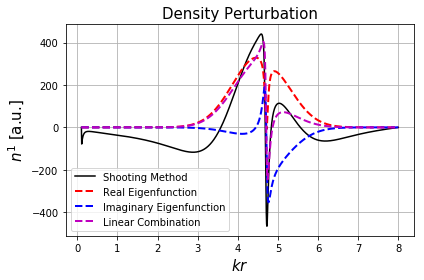

In [ ]:
#para = np.array([1, -1])
def fit_n1(r, a, b):
    return a*np.real(v[i_target[0]])+b*np.imag(v[i_target[0]])
popt, pcov = curve_fit(fit_n1, r, n1)
print(popt)

plt.plot(r, n1, label='Shooting Method', color="k")
plt.plot(r, popt[0]*v_real[int(i_target[0])], 'r', linestyle='dashed', label='Real Eigenfunction', linewidth=2)
plt.plot(r, popt[1]*np.imag(v[int(i_target[0])]), 'b', linestyle='dashed', label='Imaginary Eigenfunction', linewidth=2)
plt.plot(r, popt[0]*v_real[int(i_target[0])]+popt[1]*np.imag(v[int(i_target[0])]), 'm', linestyle='dashed', label='Linear Combination', linewidth=2)

plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('gauss_fit.png', dpi=400)
plt.show()

In [ ]:
np.sum(n1-para[0]*np.real(v[i_target[0]])-para[1]*np.imag(v[i_target[0]]))

-2139.9463307421793

In [ ]:
def fit_n1(n1, v, para):
    @njit(parallel = True)
    def fun(omega):
        np.sum(n1+para[0]*np.real(v)+para[1]]np.imag(v))
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

1

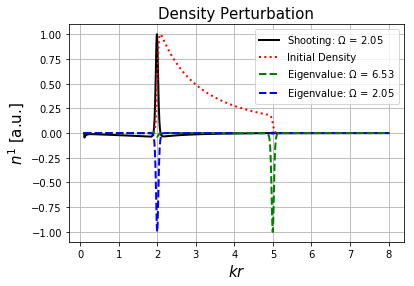

In [ ]:
plt.plot(r, n1/np.max(n1), label='Shooting: $\Omega$ = '+str(round(omega[0]/2, 2)), color="k", linewidth=2)
plt.plot(r, n0/np.max(n0), 'r', linestyle='dotted', label='Initial Density', linewidth=2)
plt.plot(r[:500], v_real[int(i_target[1])][:500]/np.max(abs(v_real[int(i_target[0])])), 'g', linestyle='dashed', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[1])])/2, 2)), linewidth=2)
plt.plot(r[:500], -v_real[int(i_target[0])][:500]/np.max(abs(v_real[int(i_target[1])])), 'b', linestyle='dashed', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[0])])/2, 2)), linewidth=2)
plt.plot(r[500:], -v_real[int(i_target[0])][500:]/np.max(abs(v_real[int(i_target[0])])), 'b', linestyle='dashed', linewidth=2)
plt.plot(r[500:], v_real[int(i_target[1])][500:]/np.max(abs(v_real[int(i_target[1])])), 'g', linestyle='dashed', linewidth=2)
plt.legend(loc=1)
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
#plt.savefig('equi_vs_pert35.png', dpi=400)
plt.show()

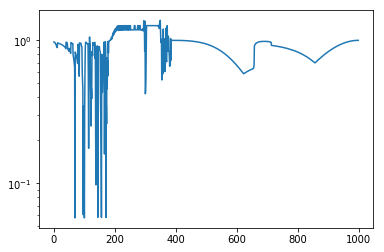

0.057390123142330496 0.2048355641971267 100
accepted 69


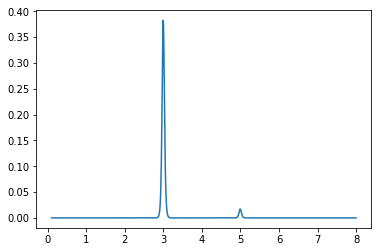

rejectred 96


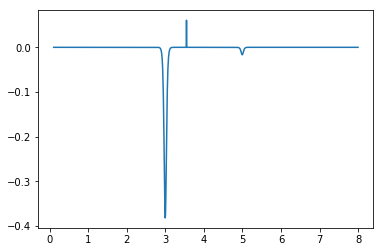

rejectred 100


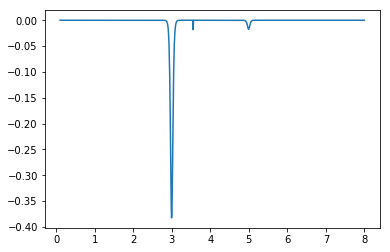

rejectred 138


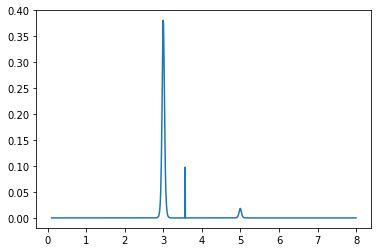

accepted 144


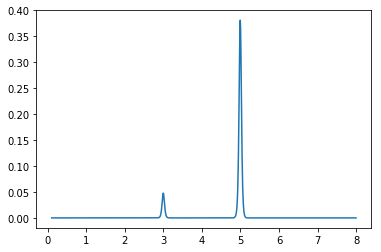

rejectred 156


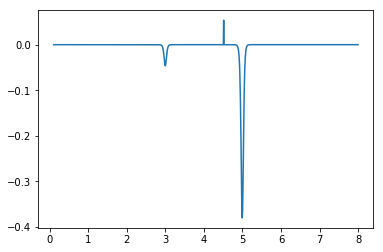

rejectred 171


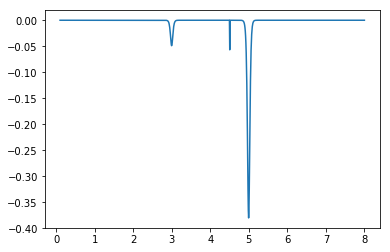

In [ ]:
sum_der = np.zeros(len(v_real))
max_v  = np.max(abs(v_real))
for i in range(len(v_real)):
    sum_der[i] = np.max(abs(v_real[i, 1:]-v_real[i, :-1])/np.max(abs(v_real)))
plt.plot(sum_der)
plt.yscale("log")
plt.show()
print(np.min(sum_der), np.std(sum_der), np.argmin(sum_der))

target = np.min(sum_der)+0.2*np.std(sum_der)
for i in range(len(v_real)-1):
    if sum_der[i] <= target:
        n = 0
        for j in range(len(v_real[0])-1):
            if abs(v_real[i][j+1]/max_v)<=1e-6 and abs(v_real[i][j-1]/max_v)<=1e-6 and abs(v_real[i][j]/max_v)>=0.01:
                n += 1
        if n == 0:
            print("accepted", i)
        else:
            print("rejectred", i)
        plt.plot(r, v_real[i])
        plt.show()


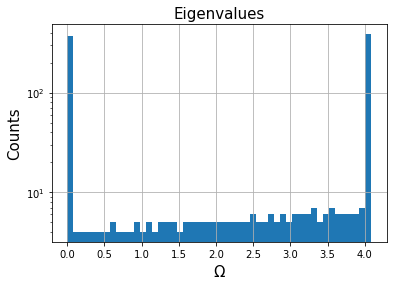

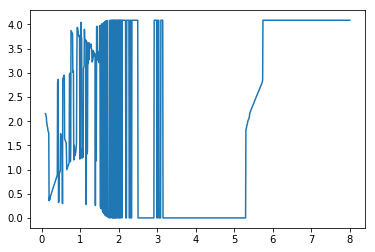

0.9737134640813574 -1.6799355856751696e-13 0.0


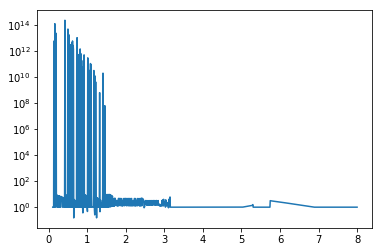

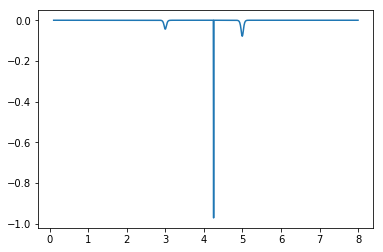

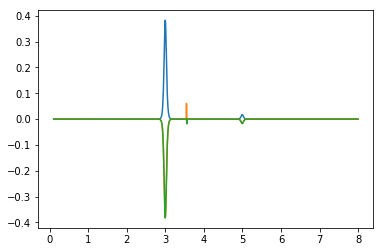

In [ ]:
plt.hist(np.real(w)/2, 50)
plt.yscale('log')
plt.xlabel('$\Omega$', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Eigenvalues', fontsize=15)
plt.grid()
plt.show()

plt.plot(r, np.real(w)/2)
plt.show()

i_max = np.argmax(v_real[0])
print(v_real[0][i_max], v_real[0][i_max-1], v_real[0][i_max+1])
dv = np.zeros(len(r))
for i in range(len(v_real)):
    dv[i] = np.max([abs(v_real[i][1:]-v_real[i][:-1])/np.max(v_real[i])])
plt.plot(r, dv)
plt.yscale('log')
plt.show()

plt.plot(r, v_real[np.argmax(dv)])
plt.show()

for i in range(len(r)):
    if abs(omega[0]-w[i])/omega[0] < 0.01:
        plt.plot(r, v_real[i])
plt.show()

In [ ]:
type(v_real[0][1:]-v_real[0][:-1])

numpy.ndarray

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
@njit(parallel=True)
def density_stuff(r, dr, n0):
    dn0 = np.zeros(len(r))
    in0 = np.zeros(len(r))

    for i in range(len(r)-1):
        dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
        in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dn0[-1] = 2*dn0[-2] - dn0[-3]
    in0[-1] = 2*in0[-2] - in0[-3]
    return dn0, in0

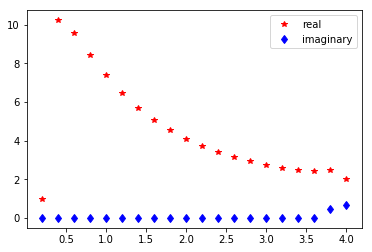

In [ ]:

r1 = np.linspace(0.2, 4, 20)
omega_r = np.empty(len(r1))
omega_i = np.empty(len(r1))
for i in range(len(r1)):
    #n0 = np.zeros(len(r))
    #n0[:i*10] = 1
    n0 = (8/r**2)*(np.tanh(25*(r-r1[i]))-np.tanh(25*(r-5)))
    dn0, in0 = density_stuff(r, dr, n0)

    bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.1]))
    omega_r[i] = bullet.x[0]
    omega_i[i] = bullet.x[1]

plt.plot(r1, omega_r, "r*", label='real')
plt.plot(r1, omega_i, "bd", label='imaginary')
plt.legend()
plt.show()

    fjac: array([[ 0.61971289, -0.7848286 ],
       [ 0.7848286 ,  0.61971289]])
     fun: array([20041.43968492, 20040.64199904])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 18
     qtf: array([-3308.74462374, 28148.54517499])
       r: array([0.00227332, 0.00070331, 0.00033932])
  status: 5
 success: False
       x: array([-79.14361025, 183.96912213])
[-39.57180513  91.98456107]


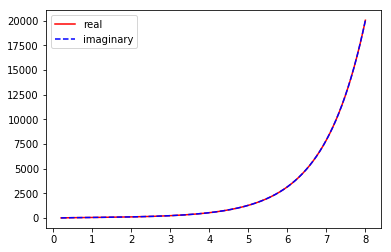

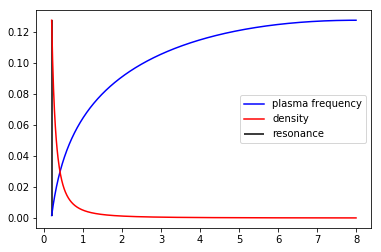

In [ ]:
#n0 = (8/r**2)*(np.tanh(25*(r-0.2))-np.tanh(25*(r-5)))
n0 = (r**-2 - R2**-2)/R1**-2
dn0, in0 = density_stuff(r, dr, n0)

bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

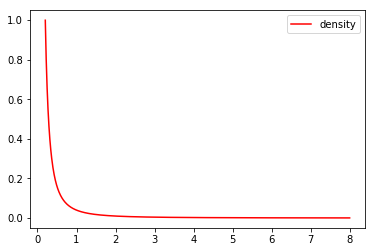

0.0


In [ ]:
n0 = (r**-2 - R2**-2)/R1**-2

plt.plot(r, n0, "r", label='density')
plt.legend()
plt.show()
print(n0[-1])